In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [191]:
BATTERY_PARTS = [
    '281700','282200','392020','392051','392119','392310', 
    '420212','721240','722230','722699','730120','730690', 
    '732619','732620','740822','740919','740921','741011', 
    '741220','741533','750522','750610','750620','760612', 
    '760719','790700','810590','831110','831120','831190', 
    '850110','850120','850590','850640','850660','850730', 
    '850780','853223','853340','854190','854370','854519', 
    '854720','860900','391910','391990','392069','731822', 
    '854449','391732','280430','290123','292390','281122', 
    '390230','853223','854720','760410','740990','853223', 
    '854720','760410','740990','282300','284210','740811', 
    '853630','382499','761699','830249','854411','848049', 
    '850790','732690','280440','854290','731816','830230', 
    '392099','401699','730711','741999','850680','853222', 
    '390210','382490','854442','282110','853890','853610', 
    '850450','732599','392690','730890','731100','853641'
]

BATTERY_PARTS_DICT = {
    'Aluminum foil': ['760410','760612','760719','761699'],
    'Anode Paste': ['281122','282110','282300','281700'],
    'Copper foil': ['740811','740822','740919','740921','740990','741011','741220','741533'],
    'Cathode': ['810590','280430'],
    'Cathode Paste': ['282200'],
    'Electrolyte': ['382499','292390','284210','290123','280440','382490'],
    'Battery Separator': ['390210','390230','401699'],
    'Anode': ['790700','854519'],
    'Cylinder Cell': ['731100'],
    'Spacer': ['392310','392020'],
    'Wire': ['831120','831190'],
    'Cases': ['721240','722230','722699','730120','730690','730890','731816','731822','732599','732619','732620','391732','391910','391990','392051','392069','392099','392690','848049','860900','854720','420212'],
    'Nickel Tab': ['750522','750610','750620'],
    'Battery Cell': ['850640','850660','850680'],
    'BMS':['850450','850730','850780','850790','853222','853223','853321','853340','853630','853641','853890','854190','854239','854290','854411','854442','854449'],
    'BATTERY': ['850760']
}
       
INV_BATTERY_PARTS_DICT = defaultdict()
for key, value in BATTERY_PARTS_DICT.items():
    for v in value:
        INV_BATTERY_PARTS_DICT[v] = key

BATTERY = '850760'

# Get Top Suppliers of Battery

In [3]:
index = pd.read_csv("s3://supply-web-data-storage/CSV/index_hs6.csv")

In [4]:
# Check for missing values
index[index['hs6'] == BATTERY].isna().sum()

supplier_t      0
supplier_id     0
buyer_t         1
buyer_id        1
hs6             0
st              0
et              0
bill_count      0
quantity_sum    0
weight_sum      0
amount_sum      0
dtype: int64

In [5]:
def generate_battery_suppliers(index, method_name=None, count=100, df_print=False):   
    if method_name is not None:
        top_suppliers_df = index[index['hs6'] == BATTERY].groupby('supplier_t').agg(
                               indicator_value=(method_name, 'sum')
                           ).sort_values(
                               ["indicator_value"], ascending = False
                           )
    else:
        raise ValueError('Must specify a method for defining largest supplier.')
    if df_print: 
        pd.set_option('display.max_rows', count+1)
        print(top_suppliers_df.head(count))
        pd.reset_option("all")
    top_suppliers = top_suppliers_df.head(count).index
    assert len(top_suppliers) == count
    return top_suppliers

In [6]:
battery_suppliers = generate_battery_suppliers(index, method_name="bill_count", df_print=True)
battery_suppliers

                                                    indicator_value
supplier_t                                                         
dell global b.v                                                6060
wistron corporation                                            3845
sevt                                                           2540
hp international sarl                                          2298
yiwu yihuang import export compan                               826
sehc                                                            689
samsung electronics vietnam thai nguyen co.,ltd                 658
cong ty tnhh dien tu samsung hcmc ce complex                    631
verdant crest technology dmcc                                   508
luxshare precision limited                                      437
railhead corporation                                            421
navitasys technology limited                                    415
motorola mobility llc                           

/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


Index(['dell global b.v', 'wistron corporation', 'sevt',
       'hp international sarl', 'yiwu yihuang import export compan', 'sehc',
       'samsung electronics vietnam thai nguyen co.,ltd',
       'cong ty tnhh dien tu samsung hcmc ce complex',
       'verdant crest technology dmcc', 'luxshare precision limited',
       'railhead corporation', 'navitasys technology limited',
       'motorola mobility llc',
       'shenzhen coman electronic technology co.,limited',
       'arnold technologies shenzhen ltd',
       'hongkong hui shun import export trading limited', 'no disponible',
       'samsung electronics co., ltd', 'wingtech group hongkong limited',
       'hefei gotion high-tech power energy co ltd',
       'apple south asia pte ltd', 'shenzhen chenshi technology co., ltd',
       'advan export hk trading co',
       'samsung electronics vietnam company limited',
       'tcl technoly electronics hui zhou co., ltd', 'lenovo pc hk limited',
       'apple distribution international'

# BFS on a supplier

In [7]:
def construct_battery_subgraph(suppliers, tiers, early_stop=True, as_nx=False, nx_kwargs=None):
    '''
    Search starts from tier 1 and exhausts after reaching tier 'tiers'. Note that 'suppliers' are tier 1.
    early_stop: Stop when BFS is exhausted despite not reaching 'tiers'. 
                Store the last explored valid tier in 'early_stop_tier', 
                otherwise 'early_stop_tier' is 'tier'
    '''
    assert tiers >= 1
    early_stop_tiers = tiers
    bom_df = index[index['hs6'].isin(BATTERY_PARTS + [BATTERY])].copy()
    bom_df = bom_df.loc[:,['supplier_t','buyer_t','hs6', 'bill_count']]

    # Find upstream suppliers by tier
    new_suppliers = set(suppliers)
    all_suppliers = set(suppliers) 
    all_suppliers_dict = dict.fromkeys(suppliers, 1) # maps supplier to tier 
    for t in range(2, tiers + 1):    
        df = bom_df[bom_df['buyer_t'].isin(new_suppliers)].copy() 
        new_suppliers  = set(df[df.supplier_t.str.len() > 0].supplier_t.unique())
        new_suppliers = new_suppliers - all_suppliers
        if early_stop and len(new_suppliers) == 0:
            early_stop_tiers = t - 1 # denotes last tier of supplier
            break
        all_suppliers = all_suppliers.union(new_suppliers)
        all_suppliers_dict.update(dict.fromkeys(new_suppliers, t))
        
    # start with edges s.t. supplier_t is in 'suppliers' and upwards
    subgraph_df = bom_df[bom_df['supplier_t'].isin(all_suppliers)].copy() 
    assert all(subgraph_df.supplier_t.str.len() > 0)
    assert all(subgraph_df.buyer_t.str.len() > 0)
    subgraph_df["tier"] = None
    if subgraph_df.shape[0] > 0:
        subgraph_df["tier"] = subgraph_df.apply(
            lambda row: all_suppliers_dict[row.supplier_t],
            axis=1
        )
    return subgraph_df.sort_values(['tier', 'buyer_t'], ascending = True), early_stop_tiers

# Analysis

In [8]:
MAX_TIER = 100

## Q1: as tier increases, when does the graph die? (trend: tier vs num_new_row)

In [9]:
# Q1.1: Size of graph (num_node) for each battery supplier (largest to smallest, top 100)
dict_ = {'supplier_t' : [], 'size' : []}
for bat in battery_suppliers:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    
    dict_['supplier_t'].append(bat)
    dict_['size'].append(len(battery_subgraph[0]))
df = pd.DataFrame(dict_)
display(df)

,supplier_t,size
0,dell global b.v,12
1,wistron corporation,70
2,sevt,3170
3,hp international sarl,39
4,yiwu yihuang import export compan,2
...,...,...
95,asus global pte.ltd,1
96,j-run trade limited,3
97,hong kong lishengyuan electronic te,1
98,samsung gulf electronics fze,3173


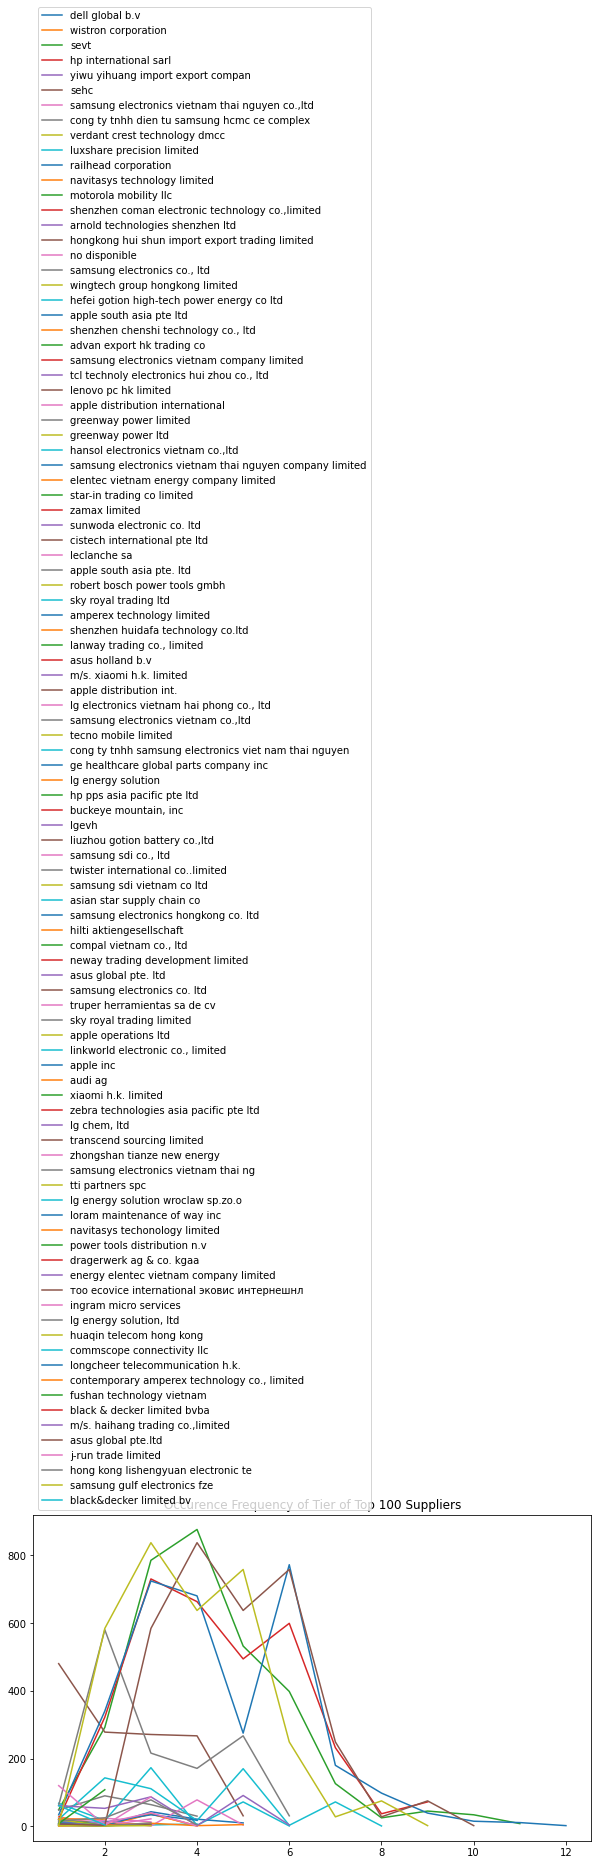

In [10]:
# Q1.2: Where's a supplier at in the supply chain? 
# A1.2: Plot for Top 100: x-axis is 'tier', y-axis is count of occurence
PLOT_CNT = 100
plt.figure(figsize=(10,6))
for bat in battery_suppliers[:PLOT_CNT]:
    battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
    assert(battery_subgraph[1] < MAX_TIER)
    tier_df = battery_subgraph[0].groupby(['tier'])['tier'].count()
    
    x = list(tier_df.index)
    y = list(tier_df.values)
    
    # check tier
    plt.plot(x, y, label = bat)

plt.legend(bbox_to_anchor=(0, 1), loc='lower left', ncol=1)
plt.title("Occurence Frequency of Tier of Top " + str(PLOT_CNT) + " Suppliers")
plt.show()

## Q2: 'hs6' vs tier as tree depth mean across top suppliers. If BOM correct, we expect the empirical plot to be consistent

In [59]:
construct_battery_subgraph(['dell global b.v'], MAX_TIER)[0]['tier'].values[0] + 1

2

In [60]:
# Construct dicts to record hs_6 code and tier list
def construct_hs6_to_tier(battery_suppliers):
    from collections import defaultdict
    hs6_dict = defaultdict(list) # set(hs_6(s)) -> tier mean, std, sum

    for bat in battery_suppliers:
        battery_subgraph = construct_battery_subgraph([bat], MAX_TIER)
        assert(battery_subgraph[1] < MAX_TIER)
        for _, row in battery_subgraph[0].iterrows():
            hs6_dict[row['hs6']].append(row['tier'])
    return hs6_dict

hs6_dict = construct_hs6_to_tier(battery_suppliers)

In [61]:
# Calculate tier info (mean, std, sum) per grouping, sum here means cnt of tx
# grouping is like BATTERY_PARTS_DICT: group_name -> list of hs6_code
def calculate_tier_info(hs6_dict, grouping=None):
    import statistics
    hs6_group_dict = defaultdict(list)
    if grouping == None:
        grouping = {hs6: [hs6] for hs6 in hs6_dict}

    for key in grouping:
        values = []
        for hs6 in grouping[key]:        
            values += hs6_dict[hs6]
        mean = statistics.mean(values)
        std = statistics.stdev(values) if len(values) > 1 else -1 # If stdev not applicable, use -1
        summ = len(values)
        hs6_group_dict[key] = [mean, std, summ]
    df = pd.DataFrame.from_dict(hs6_group_dict, orient='index', columns=['tier_mean','tier_std','tier_sum'])
    df = df.sort_values(['tier_mean'], ascending = False)
    return df

In [51]:
# Sanity check: info of BATTERY = 850760 row
# Sanity check: the ordering of index (hs6 code) should resemble BOM tree, not necessarily numerically equally-spaced

In [62]:
def plot_tier_info(df):
    # Plot of distribution of mean, sum, std
    plt.subplots(figsize=(15, 5))

    num_bins = round((max(df['tier_mean']) - min(df['tier_mean'])) * 4)

    plt.subplot(1, 3, 1)
    plt.hist(df['tier_mean'], bins=num_bins)
    plt.title('Distribution of tier mean')
    plt.xlabel('Tier Mean Value')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(df['tier_std'], bins=num_bins)
    plt.title('Distribution of tier stdev')
    plt.xlabel('Tier Stdev Value')
    plt.ylabel('Count')

    plt.subplot(1, 3, 3)
    plt.hist(df['tier_sum'], bins=num_bins)
    plt.title('Distribution of tier sum')
    plt.xlabel('Tier Sum Value')
    plt.ylabel('Count')

    # space between the plots
    plt.tight_layout()

    # show plot
    plt.show()
    
    # Per hs code: plot of mean, variance, overlapped with sum histogram
    x = np.array(df.index)
    y = np.array(df['tier_mean'].values)
    e = np.array(df['tier_std'].values)
    s = np.array(df['tier_sum'].values)

    SUM_SCALE = max(s) / 2

    plt.figure(figsize=(20, 10))
    plt.errorbar(x, y, e, linestyle='-', marker='*', ecolor='green')
    plt.bar(x, s / SUM_SCALE, alpha=0.5, label='sum') # Scaled to show trend (maximum is 2) not actual values
    plt.xticks(rotation = 90)
    plt.title("Per grouping, plot of mean with stdev error bar, overlapped with scaled sum historgram of tier values")
    plt.show()
    

,tier_mean,tier_std,tier_sum
722699,5.636364,1.813848,22
730711,5.588235,2.670647,17
850790,5.573529,2.451416,68
750610,5.437500,2.046831,32
854290,5.402439,1.942760,82
282200,5.333333,1.032796,6
760410,5.148148,2.051335,27
730890,4.783019,1.825766,106
831190,4.763636,2.301076,55
831110,4.721311,2.295874,61


/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


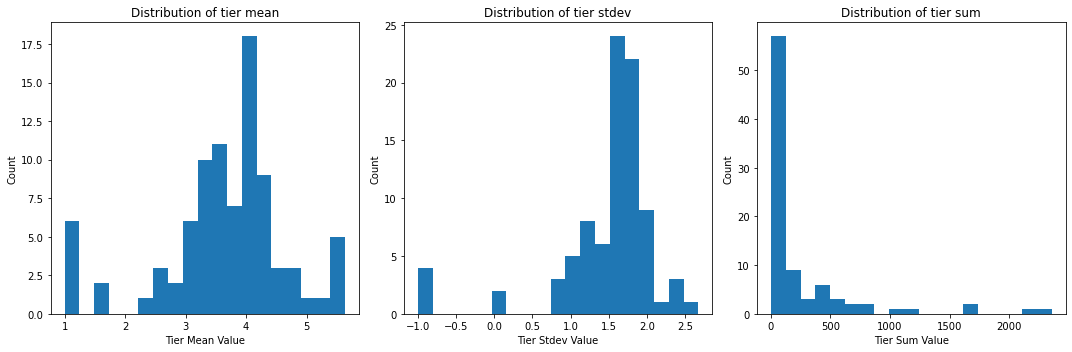

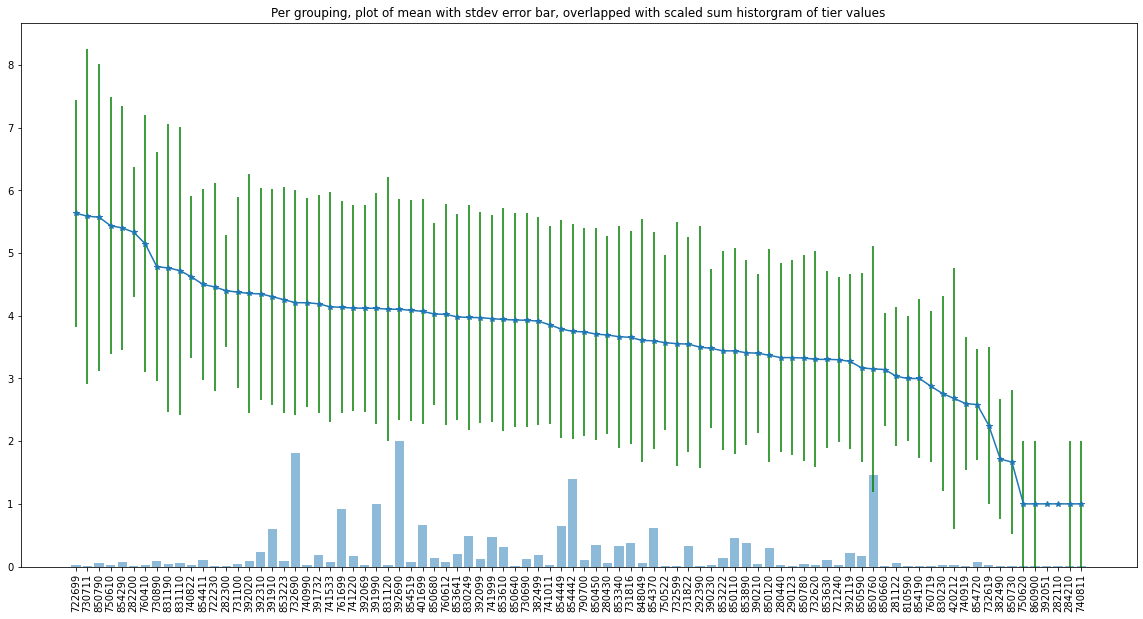

In [63]:
# Q2.1: Per hs_code, how does the graph look like?
df = calculate_tier_info(hs6_dict)
pd.set_option('display.max_rows', 100)
display(df)
pd.reset_option("all")

plot_tier_info(df)

,tier_mean,tier_std,tier_sum
Cathode Paste,5.333333,1.032796,6
Nickel Tab,5.000000,2.136376,40
Wire,4.494624,2.234238,93
Cylinder Cell,4.377358,1.521973,53
Spacer,4.351499,1.750610,367
Aluminum foil,4.132948,1.711313,1211
Copper foil,4.083551,1.677793,383
Cases,4.026255,1.785295,6018
Battery Separator,4.010381,1.760126,867
Battery Cell,3.989583,1.461512,192


/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/anaconda3/lib/python3.9/site-packages/pandas/_config/config.py:653: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


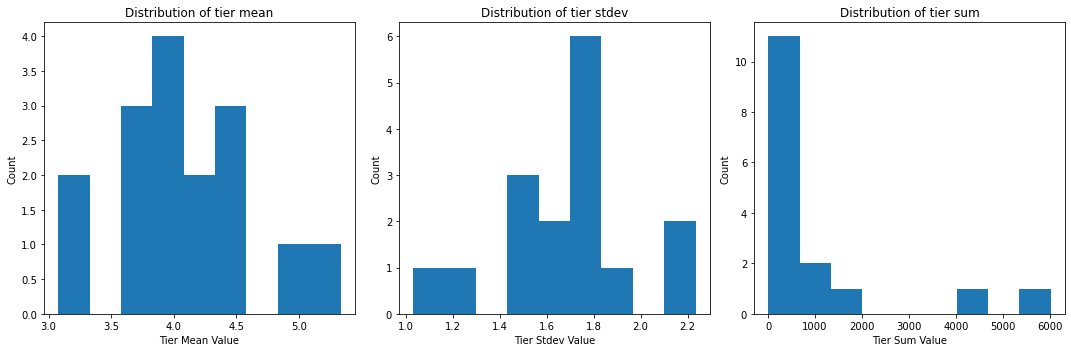

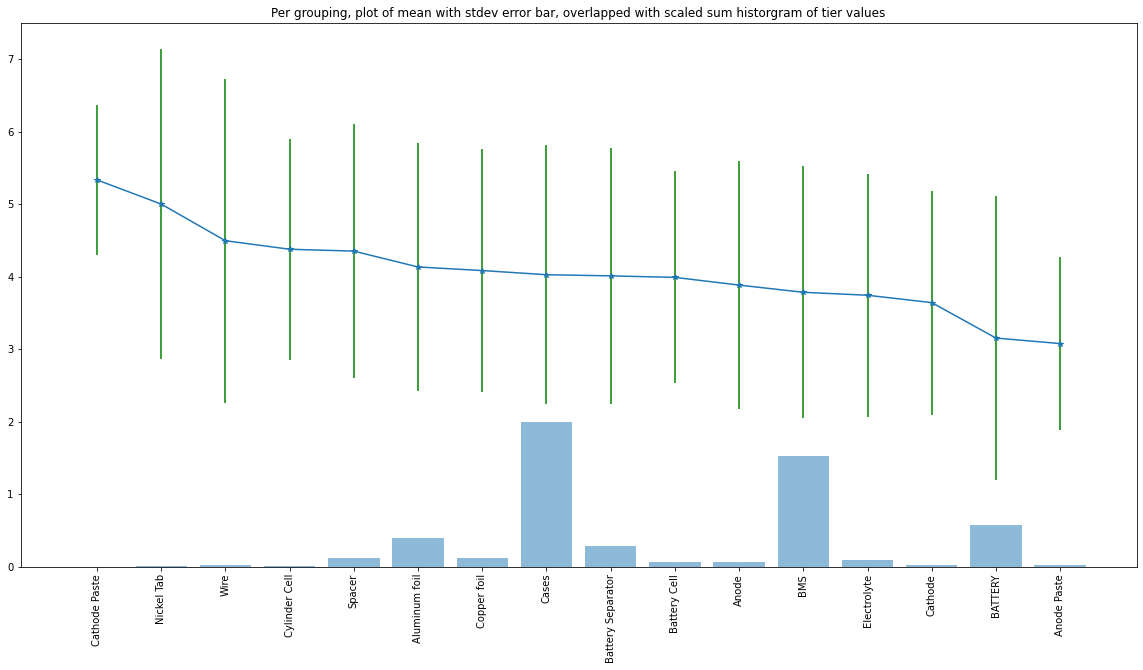

In [64]:
# Q2.2: Per bom grouping, how does the graph look like?
df = calculate_tier_info(hs6_dict, BATTERY_PARTS_DICT)
pd.set_option('display.max_rows', 100)
display(df)
pd.reset_option("all")

plot_tier_info(df)

In [ ]:
# TODO: check for specific company

## Q3: Evaluate missingness
How many hs_codes we expect to see actually show up in the subgraph of the battery makers?

In [226]:
hs6_dict.keys()

dict_keys(['850760', '761699', '854442', '382499', '391990', '392119', '392690', '401699', '420212', '732690', '830230', '830249', '850590', '850780', '854370', '854449', '391910', '853222', '392099', '850450', '853610', '853890', '850110', '848049', '850120', '741999', '853340', '741533', '854411', '854190', '854519', '280430', '760612', '280440', '290123', '731822', '831190', '741220', '731816', '850680', '392310', '740919', '732620', '853630', '853641', '730690', '831110', '391732', '730890', '790700', '281122', '282300', '760410', '392020', '853223', '390210', '740822', '740990', '741011', '750522', '854720', '721240', '854290', '731100', '831120', '292390', '722230', '850640', '850660', '810590', '850790', '750610', '390230', '732619', '760719', '392069', '730711', '722699', '732599', '282200', '750620', '860900', '392051', '282110', '284210', '382490', '850730', '740811', '281700', '740921', '730120', '853321', '854239', 1, 0])

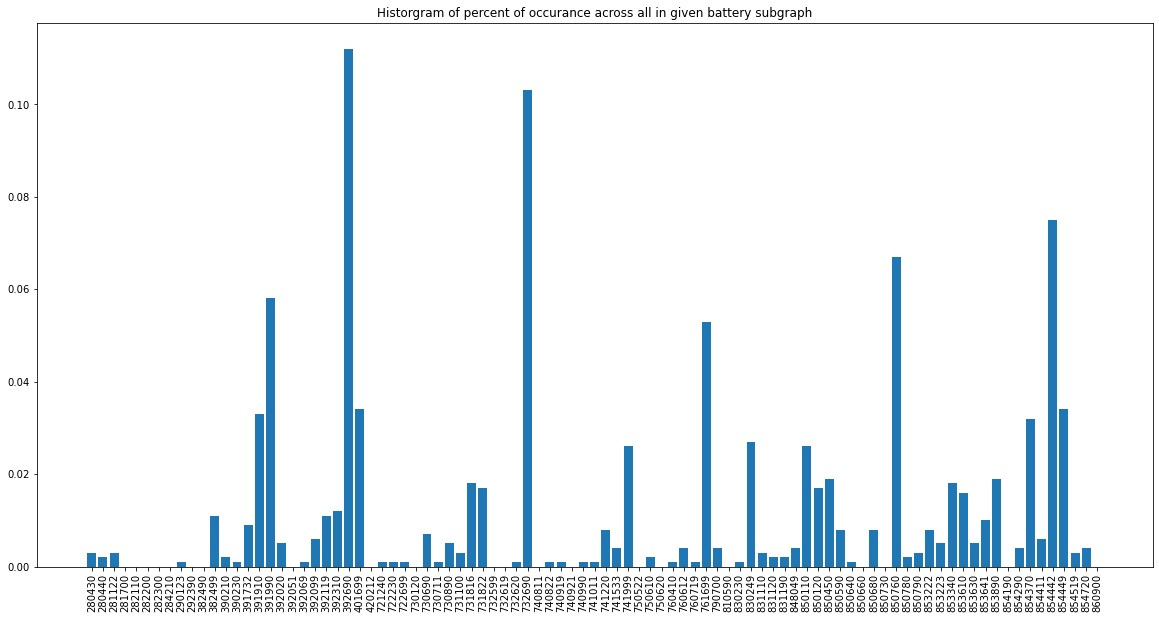

(        count  percent
 hs6                   
 392690    355    0.112
 732690    327    0.103
 854442    239    0.075
 850760    212    0.067
 391990    185    0.058
 ...       ...      ...
 282300      1    0.000
 282200      1    0.000
 732619      1    0.000
 750522      1    0.000
 810590      1    0.000
 
 [80 rows x 2 columns],
 {'281700',
  '282110',
  '284210',
  '382490',
  '392051',
  '730120',
  '740811',
  '740921',
  '750620',
  '850730',
  '860900'})

In [265]:
# Q3.1: given companies [list], construct subgraph and count distribution of hs_codes 
def evaluate_missingness(companies, plot=False):
    battery_subgraph = construct_battery_subgraph(companies, MAX_TIER)[0]
    dict_ = defaultdict(int)
    df = battery_subgraph.groupby(['hs6']).count() # col 'supplier_t' is a placeholder 
    df = df.rename(columns={"supplier_t": "count"})
    df['percent'] = round(df['count'] / df['count'].sum(), 3)
    df = df.sort_values(["count"], ascending = False)
        
    assert (set(df.index) - set(BATTERY_PARTS + [BATTERY])) == set()
    missing_parts = set(BATTERY_PARTS + [BATTERY]) - set(df.index)
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(df.index) + list(missing_parts)
        y = list(df['percent'].values) + [0] * len(missing_parts)
        
        # Sort by hs code from small to large
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Historgram of percent of occurance across all in given battery subgraph")
        plt.show()
    return df[["count", "percent"]], missing_parts

evaluate_missingness(battery_suppliers[2:3], True)

Parts in grouping holds 0.727 porportion of all hs6 codes.


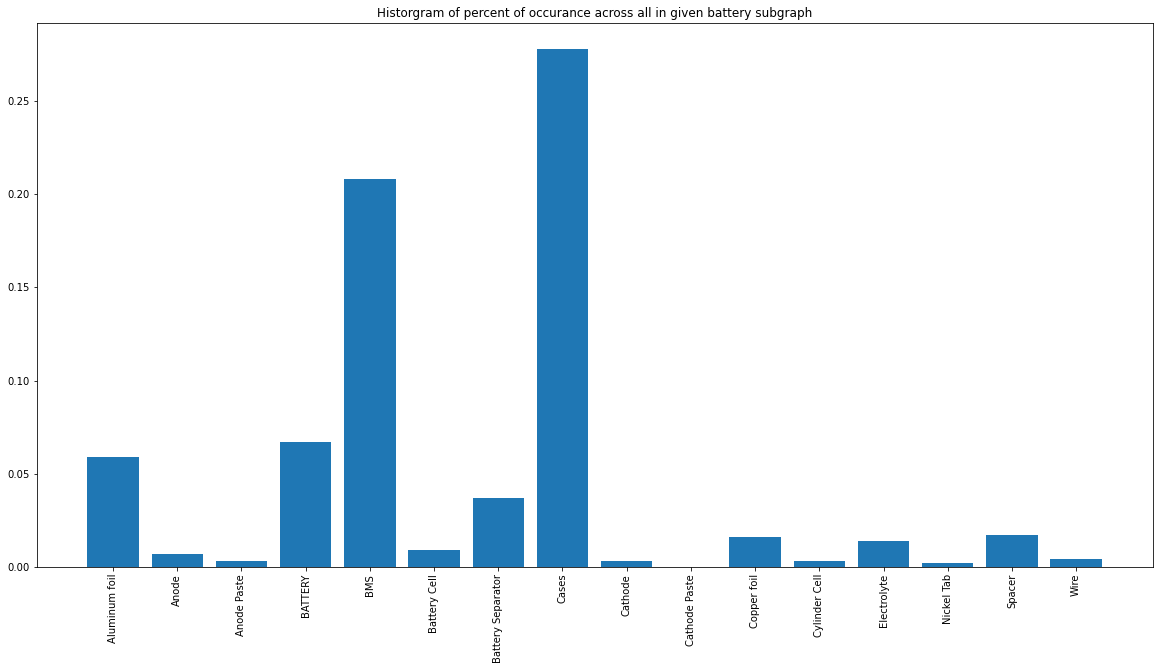

(                   count  percent
 hs6                              
 Aluminum foil        187    0.059
 Anode                 25    0.007
 Anode Paste            9    0.003
 BATTERY              212    0.067
 BMS                  661    0.208
 Battery Cell          27    0.009
 Battery Separator    119    0.037
 Cases                883    0.278
 Cathode               11    0.003
 Cathode Paste          1    0.000
 Copper foil           53    0.016
 Cylinder Cell          8    0.003
 Electrolyte           43    0.014
 Nickel Tab             6    0.002
 Spacer                53    0.017
 Wire                  12    0.004,
 {'281700',
  '282110',
  '284210',
  '382490',
  '392051',
  '730120',
  '740811',
  '740921',
  '750620',
  '850730',
  '860900'})

In [269]:
# Q3.2: given companies [list], construct subgraph and count distribution by grouping of hs_codes
def evaluate_missingness_group(companies, grouping, plot=False):
    df, missing_parts = evaluate_missingness(companies)
    df = df.groupby(by=INV_BATTERY_PARTS_DICT, axis=0).sum()
    print("Parts in grouping holds", df['percent'].sum(), "porportion of all hs6 codes.")
    if plot:
        plt.figure(figsize=(20, 10))
        x = list(df.index)
        y = list(df['percent'].values)
        
        # Sort by hs code from small to large
        zipped = list(zip(x, y))
        sorted_zipped = sorted(zipped, key=lambda x: x[0])
        x, y = zip(*sorted_zipped)
        
        plt.bar(x, y)
        plt.xticks(rotation = 90)
        plt.title("Historgram of percent of occurance across all in given battery subgraph")
        plt.show()
    return df[["count", "percent"]], missing_parts

evaluate_missingness_group(battery_suppliers[2:3], INV_BATTERY_PARTS_DICT, True)